### 1. Import Libraries 

In [1]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib notebook

In [2]:
PATH = "/home/khan74/scratch/new_DL_DES/"
sz=224
batch_size=64

In [3]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50, Xception
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd 
import numpy as np

In [5]:
import os
from os import listdir
from os.path import isfile, join, exists

### 2. Load Data / Create data_generators

In [6]:
train_df = pd.read_csv(PATH + 'deeplearning/data/training_set.csv')
val_df = pd.read_csv(PATH + 'deeplearning/data/validation_set.csv')
HP_crossmatch_df = pd.read_csv(PATH + 'deeplearning/data/high_prob_crossmatch_test_set.csv')
FO_crossmatch_df = pd.read_csv(PATH + 'deeplearning/data/full_overlap_crossmatch_test_set.csv')

#### flow_from_dir

In [7]:
train_data_dir = f'{PATH}deeplearning/data/train/'
validation_data_dir = f'{PATH}deeplearning/data/valid/'

HP_SDSS_test_data_dir = f'{PATH}deeplearning/data/HP_crossmatch_test/sdss/'
HP_DES_test_data_dir = f'{PATH}deeplearning/data/HP_crossmatch_test/des/'

FO_SDSS_test_data_dir = f'{PATH}deeplearning/data/FO_crossmatch_test/sdss/'
FO_DES_test_data_dir = f'{PATH}deeplearning/data/FO_crossmatch_test/des/'

In [8]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=45)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=45)




train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (sz, sz),
batch_size = batch_size, 
class_mode = "categorical",
shuffle = True,
interpolation = 'nearest')

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = "categorical",
shuffle = False,
interpolation = 'nearest')




HP_SDSS_test_generator = test_datagen.flow_from_directory(
HP_SDSS_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

HP_DES_test_generator = test_datagen.flow_from_directory(
HP_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)




FO_SDSS_test_generator = test_datagen.flow_from_directory(
FO_SDSS_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

FO_DES_test_generator = test_datagen.flow_from_directory(
FO_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 36620 images belonging to 2 classes.
Found 963 images belonging to 2 classes.
Found 1066 images belonging to 1 classes.
Found 1066 images belonging to 1 classes.
Found 12596 images belonging to 1 classes.
Found 12596 images belonging to 1 classes.


### 3. Load Model 

In [113]:
model_final = load_model(PATH + 'deeplearning/weights/Xception_Final.h5')

### 4. Load sklearn / Def metrics 

In [10]:
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure_size = (11, 6),
                          save=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=figure_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if save==1:
        plt.savefig('confusion_matrix.pdf')
        plt.savefig('confusion_matrix.png')

In [12]:
# Define probability threshold mask

def threshold_mask(pred_array, prob_threshold = 0.9999):
    ''' 
    returns the positions in the array where the probability for each class is greater than prob_threshold
    
    pred_array: A one-hot encoded array of softmax probability outputs 
    prob_threshold: Float b/w 0 and 1 to use as a threshold mask
    '''
    pred_class_indices = np.argmax(pred_array, axis=1)
    pos = np.where( pred_array[ range( pred_array.shape[0] ), pred_class_indices ] > prob_threshold )[0]
    return pos


In [13]:
# Define top n predictions mask

def top_pred_mask(pred_array, n_top_predictions = 5000 ):
    '''
    reversedurn the positions of top n most confident predictions
    
    pred_array: A one-reversedencoded array of softmax probability outputs
    n_top_predictions: Num of top predictions
    '''
    pred_class_indices = np.argmax(pred_array, axis=1)
    pos = np.argsort( pred_array[ range( pred_array.shape[0] ), pred_class_indices ] ) 
    mask = np.flip( pos )
    return mask[: n_top_predictions]

# Zeroth Recursion 

## Check Accuracy on FO 

### (i) SDSS 

In [14]:
FO_SDSS_predictions = model_final.predict_generator(FO_SDSS_test_generator,  verbose=1)

12596/12596 [==============================] - 868s 69ms/step


**Try Without ANY MASKS**

In [30]:
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.9999)
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_SDSS_predictions, 6000)

In [31]:
FO_SDSS_predicted_class_indices=np.argmax(FO_SDSS_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_SDSS_predicted_class_indices] )

filenames= np.array( FO_SDSS_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred Labels":predictions[mask],
                     "Predictions":FO_SDSS_predicted_class_indices[mask]})

In [32]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='SDSS_OBJID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [33]:
final[['OBJID','Predictions','Actuals', 'Pred Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Pred Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,587724241764483150,1,True,spiral,0.090,0.910
1,587731511533109391,0,False,elliptical,0.789,0.105
2,587731511533371497,0,False,elliptical,0.932,0.051
3,587731511533437052,0,False,elliptical,0.895,0.105
4,587731511533437069,0,True,elliptical,0.419,0.513


In [34]:
final.shape

(6000, 250)

In [35]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.9708333333333333
f1_score:  0.9710408737382095


<IPython.core.display.Javascript object>


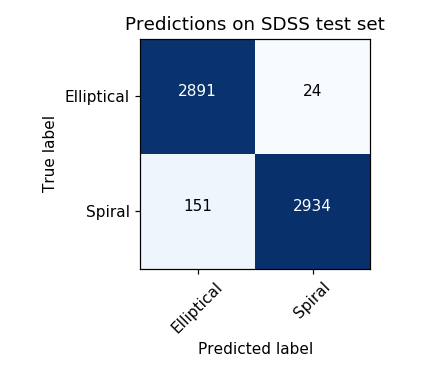

In [36]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on SDSS test set", figure_size=(4,3.4))

### (ii) DES 

In [22]:
FO_DES_predictions = model_final.predict_generator(FO_DES_test_generator,  verbose=1)

12596/12596 [==============================] - 884s 70ms/step


In [23]:
#mask = threshold_mask(FO_DES_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_DES_predictions, 6000)

In [24]:
FO_DES_predicted_class_indices=np.argmax(FO_DES_predictions,axis=1)

#FO_SDSS_predicted_class_indices = FO_SDSS_predicted_class_indices[pos]

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_DES_predicted_class_indices] )

filenames= np.array( FO_DES_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Labels":predictions[mask],
                     "Predictions":FO_DES_predicted_class_indices[mask]})

In [25]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='DES_COADD_OBJECT_ID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [26]:
final[['OBJID','Predictions','Actuals', 'Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,100005001,1,True,spiral,0.048,0.923
1,260725715,1,True,spiral,0.048,0.751
2,260422495,1,True,spiral,0.013,0.924
3,260713408,1,False,spiral,0.504,0.330
4,124112965,1,True,spiral,0.297,0.622


In [27]:
final.shape

(6000, 250)

In [28]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.9705
f1_score:  0.9753034742570114


<IPython.core.display.Javascript object>


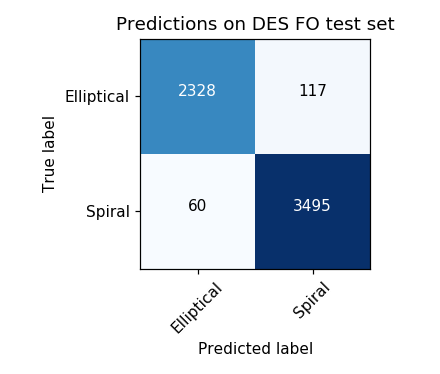

In [29]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on DES FO test set", figure_size=(4,3.4))

## Extracting Training from Unlabelled DES 

In [38]:
UL_df = pd.read_csv(PATH + 'deeplearning/data/unlabelled_test_set.csv')

In [39]:
UL_test_data_dir = f'{PATH}deeplearning/data/unlabelled/'

In [40]:
UL_test_generator = test_datagen.flow_from_directory(
UL_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 8983 images belonging to 1 classes.


In [41]:
UL_predictions = model_final.predict_generator(UL_test_generator, verbose=1)

8983/8983 [==============================] - 602s 67ms/step


In [42]:
mask = top_pred_mask(UL_predictions, 4500)

In [43]:
UL_predicted_class_indices=np.argmax(UL_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in UL_predicted_class_indices] )

filenames= np.array( UL_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred Labels":predictions[mask],
                     "Predictions":UL_predicted_class_indices[mask]})

In [45]:
mcs = np.flip( np.argsort(UL_predictions[:,1]) )[:200]
mce = np.flip( np.argsort(UL_predictions[:,0]) )[:200]

mcs_filenames= np.array( UL_test_generator.filenames )[mcs]
mce_filenames= np.array( UL_test_generator.filenames )[mce]

In [50]:
spirals = results[ results['Filename'].isin(mcs_filenames) ]
ellipticals = results[ results['Filename'].isin(mce_filenames) ]

In [64]:
training_df_1 = pd.concat([spirals, ellipticals])

In [73]:
training_df_1.Filename = training_df_1['Filename'].apply(lambda x: x.split('/')[-1] )

In [76]:
training_df_1.head()

,Filename,Pred Labels,Predictions
0,99944914.png,spiral,1
1,335831106.png,spiral,1
2,335023176.png,spiral,1
3,334971248.png,spiral,1
4,334514694.png,spiral,1


In [98]:
train_generator.class_indices

{'elliptical': 0, 'spiral': 1}

In [93]:
def plot_pred(df, start_index = 0):
    
    for i, index in enumerate( df.index[start_index:start_index+100] ):
    
        row = results.loc[index]
        filename = row.Filename
        type_ = row['Pred Labels']

        img_path = UL_test_data_dir + str(filename)

        img = plt.imread(img_path )

        plt.subplot(10,10,i+1)
        plt.axis('Off')
        plt.subplots_adjust(wspace=0.1,hspace=0.05)
        plt.imshow(img)
        plt.suptitle('Predicted ' + type_)
        
    plt.show()

<IPython.core.display.Javascript object>


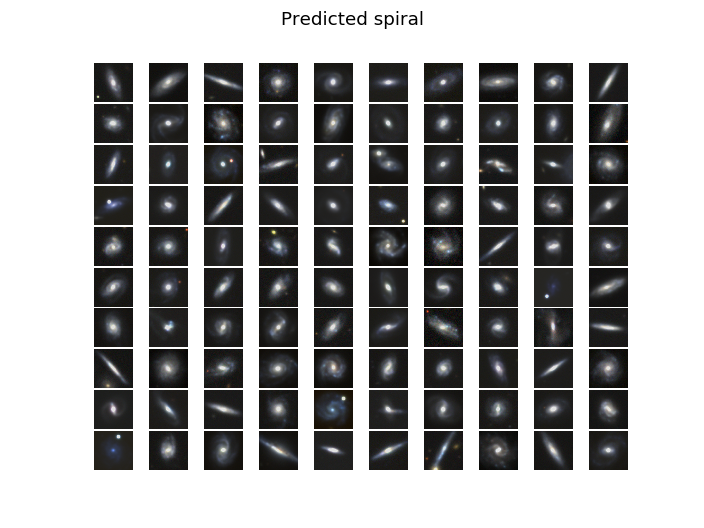

In [96]:
plot_pred(training_df_1[ training_df_1.Predictions==1 ], 100)

<IPython.core.display.Javascript object>


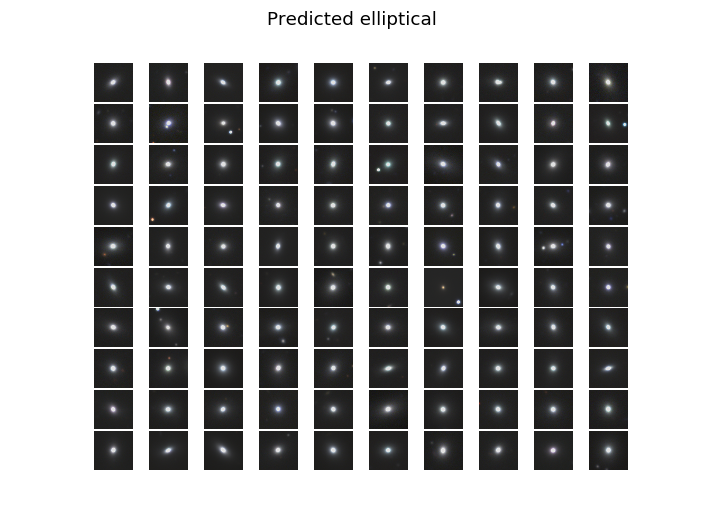

In [97]:
plot_pred(training_df_1[ training_df_1.Predictions==0 ], 100)

# 1st Recursion 

## Training 

In [80]:
rec_train_generator = train_datagen.flow_from_dataframe(
dataframe = training_df_1,
directory = UL_test_data_dir + 'test/',
x_col = 'Filename',
y_col = 'Predictions',
has_ext = True,
target_size = (sz, sz),
batch_size = batch_size,
class_mode = "categorical",
shuffle = True,
interpolation = 'nearest')

Found 400 images belonging to 2 classes.


#### Freeze all base model layers 

In [116]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [114]:
len(model_final.layers)

137

In [115]:
split_at = 133
for layer in model_final.layers[:split_at]: layer.trainable = False
for layer in model_final.layers[split_at:]: layer.trainable = True  
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [117]:
history_1 = model_final.fit_generator(
rec_train_generator,
steps_per_epoch = rec_train_generator.n // rec_train_generator.batch_size,
epochs = 1,
validation_data = validation_generator,
validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/2
6/6 [==============================] - 19s 3s/step - loss: 12.8056 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.9969
Epoch 2/2
6/6 [==============================] - 14s 2s/step - loss: 8.3533 - acc: 0.0000e+00 - val_loss: 0.0099 - val_acc: 0.9969


#### (ii) Unfreeze [at Layer 40]

In [17]:
len(model_final.layers)

137

In [18]:
split_at = 40
for layer in model_final.layers[:split_at]: layer.trainable = False
for layer in model_final.layers[split_at:]: layer.trainable = True  
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [ ]:
history_2 = model_final.fit_generator(
rec_train_generator,
steps_per_epoch = rec_train_generator.n // rec_train_generator.batch_size,
epochs = 2,
validation_data = validation_generator,
validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/20
572/572 [==============================] - 1380s 2s/step - loss: 0.0437 - acc: 0.9850 - val_loss: 0.2977 - val_acc: 0.9055

Epoch 00001: val_loss improved from inf to 0.29769, saving model to /home/khan74/scratch/new_DL_DES/deeplearning/weights/Xception_new_UnFreeze.h5
Epoch 2/20
572/572 [==============================] - 1339s 2s/step - loss: 0.0199 - acc: 0.9938 - val_loss: 0.2158 - val_acc: 0.9242

Epoch 00002: val_loss improved from 0.29769 to 0.21579, saving model to /home/khan74/scratch/new_DL_DES/deeplearning/weights/Xception_new_UnFreeze.h5
Epoch 3/20
572/572 [==============================] - 1714s 3s/step - loss: 0.0155 - acc: 0.9953 - val_loss: 0.8560 - val_acc: 0.8650

Epoch 00003: val_loss did not improve from 0.21579
Epoch 4/20
524/572 [==========================>...] - ETA: 2:24 - loss: 0.0129 - acc: 0.9963

#### (iii) Unfreeze [at Layer 2] 

In [11]:
split_at = 2
for layer in model_final.layers[:split_at]: layer.trainable = False
for layer in model_final.layers[split_at:]: layer.trainable = True  
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [ ]:
history_3 = model_final.fit_generator(
rec_train_generator,
steps_per_epoch = rec_train_generator.n // rec_train_generator.batch_size,
epochs = 2,
validation_data = validation_generator,
validation_steps = validation_generator.n // validation_generator.batch_size)

## Check Accuracy on FO 

### (i) SDSS 

In [118]:
FO_SDSS_predictions = model_final.predict_generator(FO_SDSS_test_generator,  verbose=1)

12596/12596 [==============================] - 642s 51ms/step


In [119]:
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.9999)
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_SDSS_predictions, 6000)

In [120]:
FO_SDSS_predicted_class_indices=np.argmax(FO_SDSS_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_SDSS_predicted_class_indices] )

filenames= np.array( FO_SDSS_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred Labels":predictions[mask],
                     "Predictions":FO_SDSS_predicted_class_indices[mask]})

In [121]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='SDSS_OBJID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [122]:
final[['OBJID','Predictions','Actuals', 'Pred Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Pred Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,587724241764483150,1,True,spiral,0.090,0.910
1,587731187806699711,1,True,spiral,0.383,0.414
2,587731187810828422,1,True,spiral,0.000,1.000
3,588015508213661896,1,True,spiral,0.033,0.967
4,588015508213661912,1,True,spiral,0.276,0.600


In [123]:
final.shape

(6000, 250)

In [124]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.9725
f1_score:  0.9738053659311001


<IPython.core.display.Javascript object>


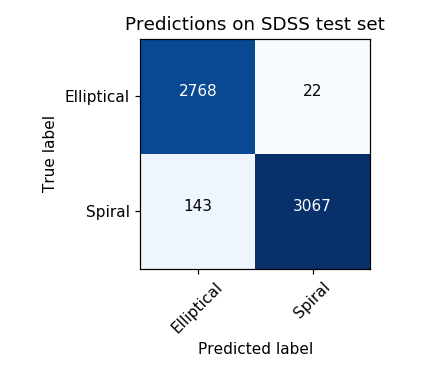

In [125]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on SDSS test set", figure_size=(4,3.4))

### (ii) DES 

In [126]:
FO_DES_predictions = model_final.predict_generator(FO_DES_test_generator,  verbose=1)

12596/12596 [==============================] - 748s 59ms/step


In [127]:
#mask = threshold_mask(FO_DES_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_DES_predictions, 6000)

In [128]:
FO_DES_predicted_class_indices=np.argmax(FO_DES_predictions,axis=1)

#FO_SDSS_predicted_class_indices = FO_SDSS_predicted_class_indices[pos]

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_DES_predicted_class_indices] )

filenames= np.array( FO_DES_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Labels":predictions[mask],
                     "Predictions":FO_DES_predicted_class_indices[mask]})

In [129]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='DES_COADD_OBJECT_ID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [130]:
final[['OBJID','Predictions','Actuals', 'Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,122650922,1,True,spiral,0.000,0.963
1,123342209,1,True,spiral,0.000,0.969
2,189056718,1,True,spiral,0.027,0.973
3,95639353,1,True,spiral,0.031,0.969
4,326304272,1,True,spiral,0.000,0.947


In [131]:
final.shape

(6000, 250)

In [132]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.97
f1_score:  0.9759807846277022


<IPython.core.display.Javascript object>


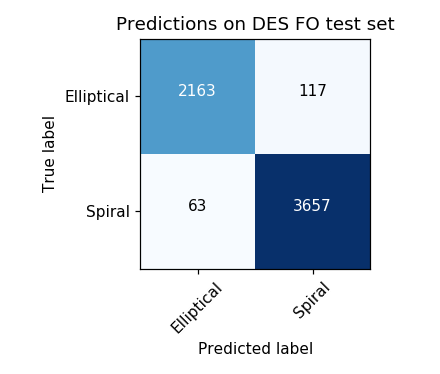

In [133]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on DES FO test set", figure_size=(4,3.4))